In [1]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'

In [200]:
# PyTorch modules
import torch
from torch import nn 
from torch.utils import data 
import torch.nn.functional as F 
from torchvision import transforms, models

# other modules
import os
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
import random
import itertools

import timm
from torch.utils.data import DataLoader
from torchvision.transforms import v2

In [3]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet50.a1_in1k"
    epochs = 50
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 6e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 100

In [4]:
device = torch.device(CFG.device)

In [5]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv'))
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [6]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)].reset_index(drop=True)
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
len(train_data)

500

In [7]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [201]:
transform = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [202]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

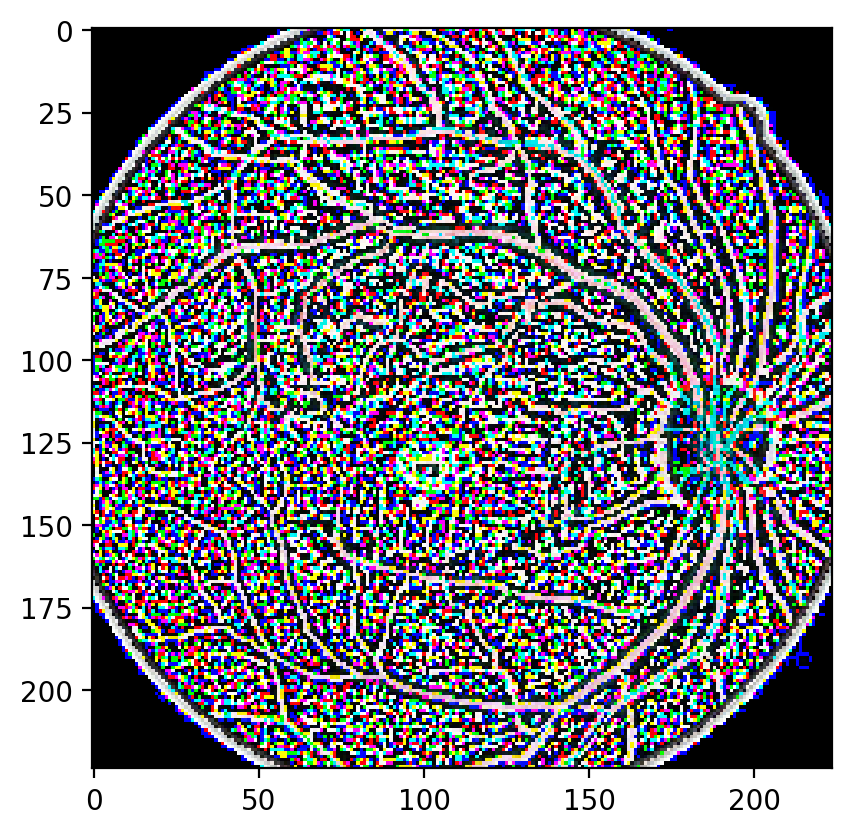

In [203]:
# visualize the transformations
train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transform)
image, label = train_dataset[15]
transformed_img_pil = func.to_pil_image(image)
plt.imshow(transformed_img_pil)

## Produce ROC and PR curves

In [204]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="aml", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aakashks_. Use `wandb login --relogin` to force relogin


In [205]:
# load model
model = timm.create_model(CFG.model_name, num_classes=5, checkpoint_path=OUTPUT_FOLDER + 'ckpt_epoch_8.pth')
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=CFG.workers)
model.eval()
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.bn1.num_batches_tracked", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.bn1.num_batches_tracked", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.bn2.num_batches_tracked", "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.bn3.num_batches_tracked", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.0.downsample.1.num_batches_tracked", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.bn1.num_batches_tracked", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.bn2.num_batches_tracked", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.1.bn3.num_batches_tracked", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.bn1.num_batches_tracked", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.bn2.num_batches_tracked", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer1.2.bn3.num_batches_tracked", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.bn1.num_batches_tracked", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.bn2.num_batches_tracked", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.bn3.num_batches_tracked", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.0.downsample.1.num_batches_tracked", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.bn1.num_batches_tracked", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.bn2.num_batches_tracked", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.1.bn3.num_batches_tracked", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.bn1.num_batches_tracked", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.bn2.num_batches_tracked", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.2.bn3.num_batches_tracked", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.bn1.num_batches_tracked", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.bn2.num_batches_tracked", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer2.3.bn3.num_batches_tracked", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.bn1.num_batches_tracked", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.bn2.num_batches_tracked", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.bn3.num_batches_tracked", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.0.downsample.1.num_batches_tracked", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.bn1.num_batches_tracked", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.bn2.num_batches_tracked", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.1.bn3.num_batches_tracked", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.bn1.num_batches_tracked", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.bn2.num_batches_tracked", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.2.bn3.num_batches_tracked", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.bn1.num_batches_tracked", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.bn2.num_batches_tracked", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.3.bn3.num_batches_tracked", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.bn1.num_batches_tracked", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.bn2.num_batches_tracked", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.4.bn3.num_batches_tracked", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.bn1.num_batches_tracked", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.bn2.num_batches_tracked", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer3.5.bn3.num_batches_tracked", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.bn1.num_batches_tracked", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.bn2.num_batches_tracked", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.bn3.num_batches_tracked", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.0.downsample.1.num_batches_tracked", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.bn1.num_batches_tracked", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.bn2.num_batches_tracked", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.1.bn3.num_batches_tracked", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.bn1.num_batches_tracked", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.bn2.num_batches_tracked", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "encoder.layer4.2.bn3.num_batches_tracked", "head.0.weight", "head.0.bias", "head.2.weight", "head.2.bias". 

need to train and then evaluate a linear classifier to evaluate these embeddings

In [ ]:
import tqdm

def evaluate_model(cfg, model, data_loader, epoch=-1):
    model.eval()

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            logits = model(images)

            targets.append(target.detach().cpu())
            predictions.append(logits.detach().cpu())
            del images, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    probabilities = F.softmax(predictions, dim=1)

    val_loss /= total_len
    # base_score, best_score, best_th = find_best_threshold(targets, predictions[:, 1])
    # For multi-class classification, you might need the class with the highest probability
    predicted_classes = predictions.argmax(dim=1)

    try:
        wandb.log({"roc": wandb.plot.roc_curve(targets.numpy(), probabilities.numpy())})
        roc_auc = roc_auc_score(targets.numpy(), probabilities.numpy(), multi_class='ovo')
        
        # wandb.log({"pr": wandb.plot.pr_curve(targets.numpy(), probabilities.numpy())})
        
        # cm = wandb.plot.confusion_matrix(
        #     y_true=targets.numpy(), preds=probabilities.numpy(), class_names=['0', '1', '2', '3', '4']
        # )

        # wandb.log({"confusion_matrix": cm})
    except:
        roc_auc = 0

    # Calculate accuracy
    accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())

    precision = precision_score(targets.numpy(), predicted_classes.numpy(), average='weighted')

    print(f'Epoch {epoch}: validation loss = {val_loss:.4f} auc = {roc_auc:.4f} accuracy = {accuracy:.4f} precision = {precision:.4f}')
    return val_loss, roc_auc, accuracy, precision